<a href="https://colab.research.google.com/github/eduardoakira/wine/blob/master/wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!git clone https://github.com/eduardoakira/wine.git

fatal: destination path 'wine' already exists and is not an empty directory.


In [3]:
# Carregando o dataset
wine = pd.read_csv('wine/datasets_4458_8204_winequality-red.csv')

In [4]:
wine.shape

(1599, 12)

In [5]:
# Checando existência de valores nulos
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# Infos
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
# Listando parametros para a maior nota possível a serem usados na verificação do funcionamento do modelo posteriormente
wine.query('quality == 8')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
267,7.9,0.35,0.46,3.6,0.078,15.0,37.0,0.99730,3.35,0.86,12.8,8
278,10.3,0.32,0.45,6.4,0.073,5.0,13.0,0.99760,3.23,0.82,12.6,8
390,5.6,0.85,0.05,1.4,0.045,12.0,88.0,0.99240,3.56,0.82,12.9,8
440,12.6,0.31,0.72,2.2,0.072,6.0,29.0,0.99870,2.88,0.82,9.8,8
455,11.3,0.62,0.67,5.2,0.086,6.0,19.0,0.99880,3.22,0.69,13.4,8
481,9.4,0.30,0.56,2.8,0.080,6.0,17.0,0.99640,3.15,0.92,11.7,8
495,10.7,0.35,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
498,10.7,0.35,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
588,5.0,0.42,0.24,2.0,0.060,19.0,50.0,0.99170,3.72,0.74,14.0,8
828,7.8,0.57,0.09,2.3,0.065,34.0,45.0,0.99417,3.46,0.74,12.7,8


In [8]:
# Verificando valores numéricos
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


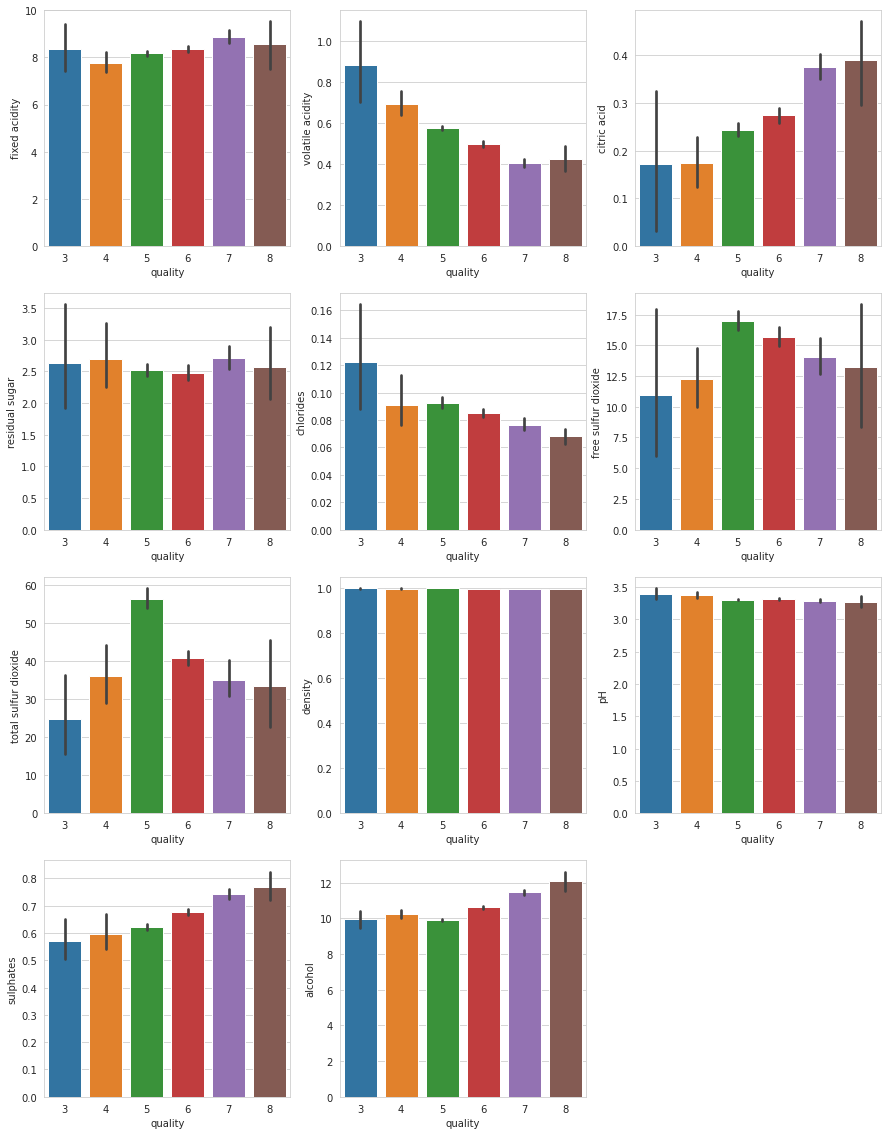

In [9]:
# Gráficos
sns.set_style("whitegrid")
fig = plt.figure(figsize = [15,20])
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
cnt = 1
for col in cols :
    plt.subplot(4,3,cnt)
    sns.barplot(data = wine, x = 'quality', y = col)
    cnt+=1
plt.show() 

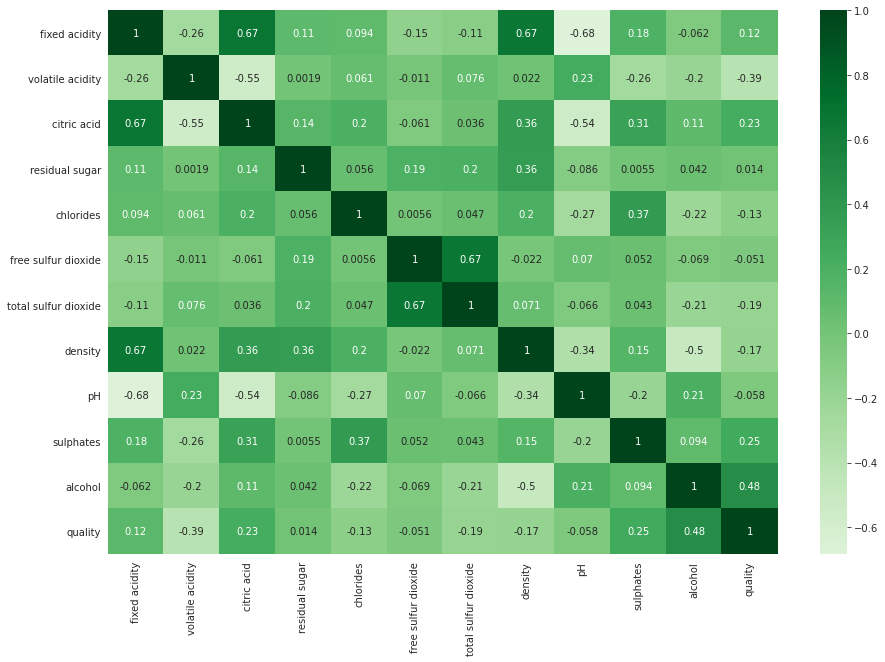

In [10]:
fig = plt.figure(figsize = [15,10])
sns.heatmap(wine.corr(),annot = True, cmap = 'Greens', center = 0)
plt.show()

In [11]:
# Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [12]:
# Now lets assign labels to our quality variable
label_quality = LabelEncoder()

In [13]:
# Bad becomes 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [14]:
wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

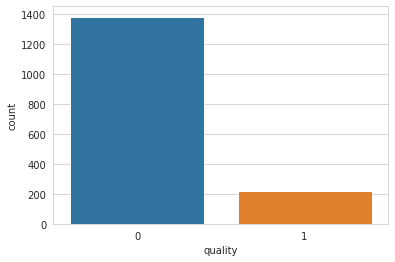

In [15]:
sns.countplot(wine['quality'])

In [16]:
# Separando o dataset em treino e target para treinamento
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [17]:
# Train and Test splitting of data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420)

In [18]:
# Normalização usando StandardScaler
sc = StandardScaler()

In [19]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [20]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, random_state=420)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       276
           1       0.70      0.43      0.54        44

    accuracy                           0.90       320
   macro avg       0.81      0.70      0.74       320
weighted avg       0.89      0.90      0.89       320



In [21]:
# Confusion matrix do Random Forest Classifier
print(confusion_matrix(y_test, pred_rfc))

[[268   8]
 [ 25  19]]


In [22]:
# Stochastic Gradient Decent Classifier
sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)
print(classification_report(y_test, pred_sgd))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       276
           1       0.69      0.25      0.37        44

    accuracy                           0.88       320
   macro avg       0.79      0.62      0.65       320
weighted avg       0.86      0.88      0.86       320



In [23]:
# Confusion matrix do Stochastic Gradient Decent Classifier
print(confusion_matrix(y_test, pred_sgd))

[[271   5]
 [ 33  11]]


In [24]:
# Support Vector Classifier
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       276
           1       0.78      0.32      0.45        44

    accuracy                           0.89       320
   macro avg       0.84      0.65      0.70       320
weighted avg       0.88      0.89      0.87       320



In [25]:
# Procurando melhores parametros pro SVC usando Grid Search CV
param = {
    'C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=10)

In [26]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [27]:
# Best parameters for our svc model
grid_svc.best_params_

{'C': 1.2, 'gamma': 1, 'kernel': 'rbf'}

In [28]:
# Let's run our SVC again with the best parameters.
svc2 = SVC(C = 1.2, gamma =  1, kernel= 'rbf')
svc2.fit(X_train, y_train)
pred_svc2 = svc2.predict(X_test)
print(classification_report(y_test, pred_svc2))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       276
           1       0.90      0.41      0.56        44

    accuracy                           0.91       320
   macro avg       0.91      0.70      0.76       320
weighted avg       0.91      0.91      0.90       320



In [29]:
# Modelo pro pickle
clf = SVC(C = 1.2, gamma =  1, kernel= 'rbf',probability=True, random_state=42)
clf.fit(X, y)

SVC(C=1.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
# Criando o pickle
import pickle

with open('wine_model.pkl', 'wb') as file:
  pickle.dump(clf, file)